# 1-mreq  语音识别

8000
(3251,) int16


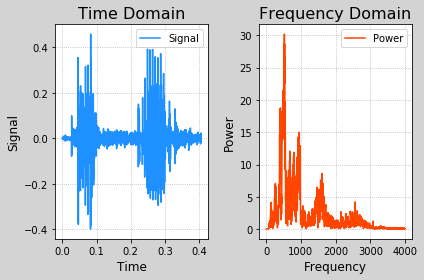

In [2]:
import numpy as np
import numpy.fft as nf
import scipy.io.wavfile as wf
import matplotlib.pyplot as mp

sample_rate, sigs = wf.read('./data/ml_data/freq.wav')
print(sample_rate)
print(sigs.shape, sigs.dtype)
sigs = sigs / 2 ** 15
times = np.arange(len(sigs)) / sample_rate
freqs = nf.fftfreq(sigs.size, 1 / sample_rate)
ffts = nf.fft(sigs)
pows = np.abs(ffts)
mp.figure('Audio', facecolor='lightgray')
mp.subplot(121)
mp.title('Time Domain', fontsize=16)
mp.xlabel('Time', fontsize=12)
mp.ylabel('Signal', fontsize=12)
mp.tick_params(labelsize=10)
mp.grid(linestyle=':')
mp.plot(times, sigs, c='dodgerblue', label='Signal')
mp.legend()
mp.subplot(122)
mp.title('Frequency Domain', fontsize=16)
mp.xlabel('Frequency', fontsize=12)
mp.ylabel('Power', fontsize=12)
mp.tick_params(labelsize=10)
mp.grid(linestyle=':')
mp.plot(freqs[freqs >= 0], pows[freqs >= 0], c='orangered', label='Power')
mp.legend()
mp.tight_layout()
mp.show()

# 2-梅尔频率倒谱系数

8000 (2694,)


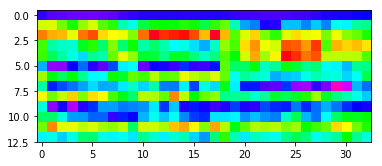

In [7]:
import numpy as np
import scipy.io.wavfile as wf
import python_speech_features as sf
import matplotlib.pyplot as mp

#采样率,采样位移S
rates,sigs=wf.read('./data/ml_data/speeches/training/apple/apple01.wav')
print(rates,sigs.shape)
mfcc = sf.mfcc(sigs, sample_rate)

mp.imshow(mfcc.T,cmap='gist_rainbow')
mp.show()

# 3speech 语音识别 (隐马尔科夫模型)

In [11]:
import os
import numpy as np
import numpy.fft as nf
import scipy.io.wavfile as wf
import matplotlib.pyplot as mp
import hmmlearn.hmm as hl
import python_speech_features as sf

# 1.读取training目录中的所有音频类别目录，并且把目录中的文件路径与目录名关联在一起
#{'apple':[url,url,url...],'banana':[url,url,url...]}
def search_files(dire):
    objects={}
    for curdir,subdirs,files in os.walk(dire):
        for file in files:
            if file.endswith('.wav'):
                #当前文件的类别标签
                label=curdir.split(os.path.sep)[-1]
                #当前文件的绝对路径
                if label not in objects:
                    objects[label]=[]
                path=os.path.join(curdir,file)
                objects[label].append(path)
    return objects
    print('curdir:',curdir)
    print('subdirs',subdirs)
    print('files',files)
train_samples=search_files('./data/ml_data/speeches/training')
# print(train_samples)
#2.解析字典，把音频的mfcc与对应的类别标签绑定在一起
train_x,train_y=[],[]
for label,filenames in train_samples.items():
    for filename in filenames:
        rates,sigs=wf.read(filename)
        mfcc=sf.mfcc(sigs,rates)
        if mfcc is None:
            mfccs=mfcc
        else:
            mfccs=np.append(mfcc,mfcc,axis=0)
    train_x.append(mfcc)
    train_y.append(label)
#3.针对每个类别，训练一个HMM模型,存储
models={}
for mfccs,label in zip(train_x,train_y):
# n_components: 用几个高斯分布函数拟合样本数据
# covariance_type: 相关矩阵的辅对角线进行相关性比较
# n_iter: 最大迭代上限
    model=hl.GaussianHMM(n_components=4, covariance_type='diag', n_iter=1000)
    models[label]=model.fit(mfccs)
#4.读取测试数据，针对每个测试音频，分别使用不同的HMM模型进行模式匹配，获得得分，取得分最高的HMM所对应的类别为预测结果。
test_samples=search_files('./data/ml_data/speeches/testing')
# print(train_samples)


#2.解析字典，把音频的mfcc与对应的类别标签绑定在一起
test_x,test_y=[],[]
for label,filenames in test_samples.items():
    mfccs=None
    for filename in filenames:
        rates,sigs=wf.read(filename)
        mfcc=sf.mfcc(sigs,rates)
        if mfccs is None:
            mfccs=mfcc
        else:
            mfcc=np.append(mfccs,mfcc,axis=0)
    test_x.append(mfccs)
    test_y.append(label)
#5.针对每一个测试音频，分别使用不同的HMM模型进行模式匹配，获得得分，取得得分最高的HMM所对应的类别标签为预测结果

pred_labels=[]
for mfccs in test_x: #7个测试样本，遍历7次
    best_label,best_score=None,None
    for label,model in models.items():
        score=model.score(mfccs)
        if (best_score is None)or(best_score<score):
            best_label=label
            best_score=score
    pred_labels.append(best_label)

print(test_y)
print(pred_labels)

# 使用模型匹配测试mfcc矩阵的分值
# score = model.score(test_mfcc)

['pineapple', 'kiwi', 'apple', 'banana', 'peach', 'orange', 'lime']
['pineapple', 'kiwi', 'pineapple', 'banana', 'peach', 'orange', 'lime']


# 4-语音识别

In [12]:
import json
import numpy as np
import scipy.io.wavfile as wf
with open('./data/ml_data/12.json', 'r') as f:
    freqs = json.loads(f.read())
tones = [
    ('G5', 1.5),
    ('A5', 0.5),
    ('G5', 1.5),
    ('E5', 0.5),
    ('D5', 0.5),
    ('E5', 0.25),
    ('D5', 0.25),
    ('C5', 0.5),
    ('A4', 0.5),
    ('C5', 0.75)]
sample_rate = 44100
music = np.empty(shape=1)
for tone, duration in tones:
    times = np.linspace(0, duration, duration * sample_rate)
    sound = np.sin(2 * np.pi * freqs[tone] * times)
    music = np.append(music, sound)
music *= 2 ** 15
music = music.astype(np.int16)
wf.write('./data/ml_data/music.wav', sample_rate, music)

# 5- OpenCV

In [ ]:
import numpy as np
import cv2 as cv
# 读取图片并显示
original = cv.imread('./data/ml_data/forest.jpg')
print(original.shape,original[0][0])
cv.imshow('Original', original)
#阻塞，等待关闭，期间会一直显示
# cv.waitkey()

# 显示图片某个颜色通道的图像
blue = np.zeros_like(original)
blue[:, :, 0] = original[:, :, 0]  # 0 - 蓝色通道
cv.imshow('Blue', blue)

green = np.zeros_like(original)
green[:, :, 1] = original[:, :, 1]  # 1 - 绿色通道
cv.imshow('Green', green)

red = np.zeros_like(original)
red[:, :, 2] = original[:, :, 2]  # 2 - 红色通道
cv.imshow('Red', red)

# 图像裁剪(本质就是三维数组的切片)
h, w = original.shape[:2]
l, t = int(w / 4), int(h / 4)
r, b = int(w * 3 / 4), int(h * 3 / 4)
#裁剪结果
cropped = original[t:b, l:r]
cv.imshow('Cropped', cropped)

#图像缩放 interpolation=线型插值
            #重置尺寸
scaled1 = cv.resize(original, (int(w / 4), int(h / 4)),
    interpolation=cv.INTER_LINEAR)
cv.imshow('Scaled1', scaled1)
#为了防止失真，最终做出一个4*4的图
scaled2 = cv.resize(
    scaled1, None, fx=4, fy=4,
    interpolation=cv.INTER_LINEAR)
cv.imshow('Scaled2', scaled2)
cv.waitKey()
# 图像文件保存
cv.imwrite('./data/ml_data/bbianyuanshibielue.jpg', blue)
cv.imwrite('./data/ml_data/green.jpg', green)
cv.imwrite('./data/ml_data/red.jpg', red)
cv.imwrite('./data/ml_data/cropped.jpg', cropped)
cv.imwrite('./data/ml_data/scaled1.jpg', scaled1)
cv.imwrite('./data/ml_data/scaled2.jpg', scaled2)

# 6-canny- 边缘检测

In [13]:
import cv2 as cv

#读取图片并且做灰度处理
img=cv.imread('./data/ml_data/chair.jpg',cv.IMREAD_GRAYSCALE)
print(img.shape)
cv.imshow('chair',img)

#Sobel水平边缘识别
hsobel=cv.Sobel(img,cv.CV_64F,1,0,ksize=5)
cv.imshow('hsobel',hsobel)
#Sobel垂直边缘识别
vsobel=cv.Sobel(img,cv.CV_64F,0,1,ksize=5)
cv.imshow('vsobel',hsobel)
#Sobel边缘识别
sobel=cv.Sobel(img,cv.CV_64F,1,1,ksize=5)
cv.imshow('sobel',hsobel)

#拉普拉斯边缘识别
lapacian=cv.Laplacian(img,cv_64F)
cv.imshow('lapacian',lapacian)

#Canny边缘识别
canny=cv.Canny(img,50,10)
cv.imshow('canny',canny)
cv.waitkey()

(667, 500)


NameError: name 'cv_64F' is not defined

# 7-equalizehist-直方图均值化提高亮度

In [1]:

import cv2 as cv
img=cv.imread('./data/ml_data/sunrise.jpg')
cv.imshow('Sunrise',img)
gray=cv.cvtColor(img,cv.COLOR_BGR2GRAY)
cv.imshow('gray',gray)
#直方图均衡化提高图像亮度
equalized_gray=cv.equalizeHist(gray)
cv.imshow('equalized_gray',equalized_gray)

#提亮彩色图   YUV:亮度、色度、饱和度
yuv=cv.cvtColor(img,cv.COLOR_BGR2YUV)
yuv[:,:,0]=cv.equalizeHist(yuv[:,:,0])
equalized_color=cv.cvtColor(yuv,cv.COLOR_YUV2BGR)
cv.imshow('equalized_color',equalized_color)
cv.waitkey()

ModuleNotFoundError: No module named 'cv2'

# 8-harrs- 角点检测

In [2]:
import cv2 as cv

original = cv.imread('./data/ml_data/box.png')
cv.imshow('Original', original)
gray = cv.cvtColor(original, cv.COLOR_BGR2GRAY)
cv.imshow('Gray', gray)
corners = cv.cornerHarris(gray, 7, 5, 0.04)
mixture = original.copy()
mixture[corners > corners.max() * 0.01] = [0, 0, 255]
cv.imshow('Corner', mixture)
cv.waitKey()

ModuleNotFoundError: No module named 'cv2'

# 9- star特征点检测

In [ ]:
import cv2 as cv
original = cv.imread('./data/ml_data/table.jpg')
cv.imshow('Original', original)
gray = cv.cvtColor(original, cv.COLOR_BGR2GRAY)
cv.imshow('Gray', gray)
star = cv.xfeatures2d.StarDetector_create()
keypoints = star.detect(gray)
mixture = original.copy()
cv.drawKeypoints(
    original, keypoints, mixture,
    flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imshow('Mixture', mixture)
cv.waitKey()mixture

# 10-SIFT特征点检测

In [4]:
import cv2 as cv

original = cv.imread('./data/ml_data/table.jpg')
cv.imshow('Original', original)
gray = cv.cvtColor(original, cv.COLOR_BGR2GRAY)
cv.imshow('Gray', gray)
sift = cv.xfeatures2d.SIFT_create()
keypoints = sift.detect(gray)
mixture = original.copy()
cv.drawKeypoints(original, keypoints, mixture,
    flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imshow('Mixture', mixture)
cv.waitKey()

ModuleNotFoundError: No module named 'cv2'

# 11-特征值矩阵

In [5]:
import cv2 as cv

import matplotlib.pyplot as mp
original = cv.imread('./data/ml_data/table.jpg')
cv.imshow('Original', original)
gray = cv.cvtColor(original, cv.COLOR_BGR2GRAY)
cv.imshow('Gray', gray)
sift = cv.xfeatures2d.SIFT_create()
keypoints = sift.detect(gray)
_, desc = sift.compute(gray, keypoints)
print(desc.shape)
mp.matshow(desc, cmap='jet', fignum='Description')
mp.title('Description', fontsize=20)
mp.xlabel('Feature', fontsize=14)
mp.ylabel('Sample', fontsize=14)
mp.tick_params(which='both', top=False, labeltop=False, labelbottom=True, labelsize=10)
mp.show()

AttributeError: module 'cv2.cv2' has no attribute 'xfeatures2d'

# 12-物体识别

In [ ]:
import os
import numpy as np
import cv2 as cv
import hmmlearn.hmm as hl

def search_files(directory):
    directory = os.path.normpath(directory)

    objects = {}
    for curdir, subdirs, files in os.walk(directory):
        for file in files:
            if(file.endswith('.jpg')):
                label = curdir.split(os.path.sep)[-1]
                if label not in objects:
                    objects[label] = []
                path = os.path.join(curdir, file)
                objects[label].append(path)
    return objects
	
#加载训练集样本数据，训练模型，模型存储
train_objects = search_files('./data/ml_data/objects/training')
#2.解析字典，把图像的desc与对应类别标签绑定在一起
train_x, train_y = [], []
for label, filenames in train_objects.items():
    descs = np.array([])
    for filename in filenames:
        image = cv.imread(filename)
        #转成灰度图
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        #范围缩放，使特征描述矩阵样本数量一致
        #修整图片大小
        h, w = gray.shape[:2]
        f = 200 / min(h, w)      #计算缩放比
        gray = cv.resize(gray, None, fx=f, fy=f)
        sift = cv.xfeatures2d.SIFT_create()
        keypoints = sift.detect(gray)
        _, desc = sift.compute(gray, keypoints)
        if len(descs) == 0:
            descs = desc
        else:
            descs = np.append(descs, desc, axis=0)
    train_x.append(descs)
    train_y.append(label)
models = {}
for descs, label in zip(train_x, train_y):
    model = hl.GaussianHMM(n_components=4, covariance_type='diag', n_iter=100)
    models[label] = model.fit(descs)


#测试模型
test_objects = search_files('./data/ml_data/objects/testing')
test_x, test_y = [], []
for label, filenames in test_objects.items():
    descs = np.array([])
    for filename in filenames:
        image = cv.imread(filename)
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        sift = cv.xfeatures2d.SIFT_create()
        keypoints = sift.detect(gray)
        _, desc = sift.compute(gray, keypoints)
        if len(descs) == 0:
            descs = desc
        else:
            descs = np.append(descs, desc, axis=0)
    test_x.append(descs)
    test_y.append(label)

# 遍历所有测试样本  使用model匹配测试样本查看每个模型的匹配分数
for descs, test_label in zip(test_x, test_y):
    for pred_label, model in models.items():
        score = model.score(descs)
        print(test_label, '->', pred_label, score)

# 13-video opencv操作视频捕获设备

In [3]:
import cv2 as cv

#获取视频头对象     0:下标为0的设备
video_capture=cv.VideoCapture(0)
#获取实时采集的一张图片
while True:
    frame=video_capture.read()[1]
    #针对frame做图像处理   （基于视频的实时处理）
    cv.imshow('frame',frame)
    if cv.waitKey(33)==27:
        break
#释放
video_apture.release()
cv.destroyAllwindows()

error: OpenCV(4.1.1) /io/opencv/modules/highgui/src/window.cpp:352: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'imshow'


# 14-哈儿级联人脸定位器

In [ ]:
import cv2 as cv
# 哈尔级联人脸定位器
            #级联分级机
fd = cv.CascadeClassifier('./data/ml_data/haar/face.xml')
ed = cv.CascadeClassifier('./data/ml_data/haar/eye.xml')
nd = cv.CascadeClassifier('./data/ml_data/haar/nose.xml')
vc = cv.VideoCapture(0)
while True:
    frame = vc.read()[1]
    faces = fd.detectMultiScale(frame, 1.3, 5)
    #左、上、宽、高
    for l, t, w, h in faces:
        a, b = int(w / 2), int(h / 2)
        cv.ellipse(frame, (l + a, t + b), (a, b), 0, 0, 360, (255, 0, 255), 2)
        #识别脸
        face = frame[t:t + h, l:l + w]
        #眼
        eyes = ed.detectMultiScale(face, 1.3, 5)
        for l, t, w, h in eyes:
            a, b = int(w / 2), int(h / 2)
            cv.ellipse(face, (l + a, t + b), (a, b), 0, 0, 360, (0, 255, 0), 2)
        #鼻子
        noses = nd.detectMultiScale(face, 1.3, 5)
        for l, t, w, h in noses:
            a, b = int(w / 2), int(h / 2)
            cv.ellipse(face, (l + a, t + b), (a, b), 0, 0, 360, (0, 255, 255), 2)
    cv.imshow('VideoCapture', frame)
    if cv.waitKey(33) == 27:
        break
vc.release()
cv.destroyAllWindows()